Training on device cpu.
<class 'torch.Tensor'>
Concatenated TESTING images: 435 and labels pair: 435 :


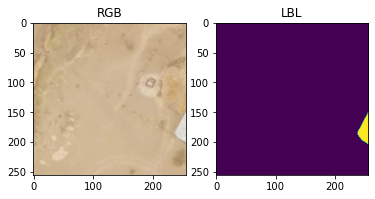

In [30]:
##############################
#Training loop for NNs       #
#Maintainer: Christopher Chan#
#Version: 0.3.2              #
#Date: 2022-05-29            #
##############################

import os
import sys
import torch
import pathlib
import time
import re
import PIL
import random
#import ray
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch.nn as nn
import segmentation_models_pytorch as smp
#from ray import tune
#from ray.tune.suggest.bohb import TuneBOHB
#from ray.tune.schedulers import HyperBandForBOHB
from scipy import ndimage
from PIL import Image
from torch import optim
from tqdm import tqdm
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader, random_split, ChainDataset, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
from Networks import Five_UNet, Four_UNet
from dataloader import BuildingDataset
%matplotlib inline

device = (torch.device("cuda") if torch.cuda.is_available()
          else torch.device("cpu"))

print(f"Training on device {device}.")

data_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/SAMPLE")

TestIMG_ls = []
TestLBL_ls = []

for root, dirs, filename in os.walk(os.path.join(data_path, "Test_15cm", "IMG")):
    for i in filename:
        #if i.startswith("KBY15_IMG"):
            TestIMG_ls.append(root + "/" + i)

for i in TestIMG_ls:
    i = re.sub("IMG", "LBL", i, count = 2)
    TestLBL_ls.append(i)

#plot a sample
test = BuildingDataset(TestIMG_ls, TestLBL_ls, transform = None)
test_pair = random.choice(test)

assert len(test.png_dir) == len(test.lbl_dir)

print(type(test_pair[0]))

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
RGB = plt.imshow(test_pair[0].cpu().numpy().transpose(1, 2, 0))
ax.set_title('RGB')

ax = fig.add_subplot(1, 2, 2)
LBL = plt.imshow(test_pair[1].cpu().numpy().transpose(1, 2, 0))
ax.set_title('LBL')

assert len(test.png_dir) == len(test.lbl_dir)

print("Concatenated TESTING images: {0} and labels pair: {0} :".format(len(test.png_dir)))
#for x, y in zip(test.png_dir, test.lbl_dir):
#    print(f"Image: {x}", f"Label: {y}")

In [31]:
qubvelEB1_UNet = smp.Unet(encoder_name = 'efficientnet-b1', encoder_depth = 5, encoder_weights = None, decoder_use_batchnorm = True, decoder_channels = (256, 128, 64, 32, 16), decoder_attention_type = None, in_channels = 3, classes = 1, activation = "sigmoid", aux_params = None)
qubvel_weights = os.path.abspath("/home/chris/Dropbox/HOTOSM/qubvel_UNet/weights/stage3/effb1-f0/checkpoints/best.pth")
qubvel_weights = torch.load(qubvel_weights, map_location = device)
qubvelEB1_UNet.load_state_dict(qubvel_weights["state_dict"])
qubvelEB1_UNet.to(device = device)

print(sum(p.numel() for p in qubvelEB1_UNet.parameters() if p.requires_grad == True))

8757105


In [32]:
# Loading testing batch
test_loader = DataLoader(test, batch_size = 1, shuffle = True)
qubvelEB1_UNet.to(device = device)

idx = []
png_ls = []
Dice_ls = []
TP_ls = []
TN_ls = []
FN_ls = []
FP_ls = []
Precision_ls = []
Recall_ls = []
Specificity_ls = []
OA_ls = []
IoU_ls = []

for i, (img, lbl) in tqdm(enumerate(test_loader), total = len(test_loader)):
    img = img.to(device = device)
    lbl = lbl.to(device = device)

    with torch.no_grad():
        prediction = qubvelEB1_UNet(img)
        prediction = prediction.squeeze(0)
        lbl = lbl.squeeze(0)

        pred_BOOL = (prediction > 0.001).to(torch.float32)

        # Booleanise
        pred_BOOL = pred_BOOL.bool()
        lbl = lbl.bool()

        # 1st order statistics
        TP = (pred_BOOL * lbl).sum(dim = [0, 1, 2])
        TN = ((~pred_BOOL) * (~lbl)).sum(dim = [0, 1, 2])
        FN = ((~pred_BOOL) * lbl).sum(dim = [0, 1, 2])
        FP = (pred_BOOL * (~lbl)).sum(dim = [0, 1, 2])

        # 2nd order statistics
        Precision = (TP / (TP + FP))
        Recall = (TP / (TP + FN)) #True Positive Rate / Sensitivity
        Specificity = (TN / (FP + TN)) #True Negative Rate
        OA = ((TP + TN) /(TP + TN + FP + FN))
        IoU = (TP / (TP + FN + FP))
        Dice = (2 * ((Precision * Recall) / (Precision + Recall)))

        TP = TP.detach().cpu().numpy()
        TN = TN.detach().cpu().numpy()
        FN = FN.detach().cpu().numpy()
        FP = FP.detach().cpu().numpy()
        Precision = Precision.detach().cpu().numpy()
        Recall = Recall.detach().cpu().numpy()
        Specificity = Specificity.detach().cpu().numpy()
        OA = OA.detach().cpu().numpy()
        IoU = IoU.detach().cpu().numpy()
        Dice = Dice.detach().cpu().numpy()

        idx.append(i)
        TP_ls.append(TP)
        TN_ls.append(TN)
        FN_ls.append(FN)
        FP_ls.append(FP)
        Precision_ls.append(Precision)
        Recall_ls.append(Recall)
        Specificity_ls.append(Specificity)
        OA_ls.append(OA)
        IoU_ls.append(IoU)
        Dice_ls.append(Dice)

for j in test.png_dir:
    png_ls.append(os.path.basename(j))

df = {"id": idx,
      "png": png_ls,
      "Dice_score": Dice_ls,
      "True_Positive": TP_ls,
      "True_Negative": TN_ls,
      "False_Negative": FN_ls,
      "False_Positive": FP_ls,
      "Precision": Precision_ls,
      "Recall": Recall_ls,
      "Specificity": Specificity_ls,
      "Overall Accuracy": OA_ls,
      "IoU": IoU_ls}
    
TP_SUM = np.sum(df["True_Positive"])
TN_SUM = np.sum(df["True_Negative"])
FP_SUM = np.sum(df["False_Positive"])
FN_SUM = np.sum(df["False_Negative"])

# 2nd order statistics
GLOB_Precision = (TP_SUM / (TP_SUM + FP_SUM))
GLOB_Recall = (TP_SUM / (TP_SUM + FN_SUM)) #True Positive Rate / Sensitivity
GLOB_Specificity = (TN_SUM / (FP_SUM + TN_SUM)) #True Negative Rate
GLOB_OA = ((TP_SUM + TN_SUM) / (TP_SUM + TN_SUM + FP_SUM + FN_SUM))
GLOB_IoU = (TP_SUM / (TP_SUM + FN_SUM + FP_SUM))
GLOB_Dice = (2 * ((GLOB_Precision * GLOB_Recall) / (GLOB_Precision + GLOB_Recall)))

results_csv = pd.DataFrame(df)

print("Per Window statistics: mean Dice Score = {0}, mean Precision = {1}, mean Recall = {2}, mean Specificity = {3}, mean OA = {4}, mean IoU = {5}".format(np.nanmean(Dice_ls), np.nanmean(Precision_ls), np.nanmean(Recall_ls), np.nanmean(Specificity_ls), np.nanmean(OA_ls), np.nanmean(IoU_ls)))
print("\n")
print("GLOBAL statistics: Dice Score = {0}, Precision = {1}, Recall = {2}, Specificity = {3}, OA = {4}, IoU = {5}".format(GLOB_Dice, GLOB_Precision, GLOB_Recall, GLOB_Specificity, GLOB_OA, GLOB_IoU))

100%|██████████████████████████████████████████████| 435/435 [01:12<00:00,  5.98it/s]

Per Window statistics: mean Dice Score = 0.5098835825920105, mean Precision = 0.8002525568008423, mean Recall = 0.4331878125667572, mean Specificity = 0.9904452562332153, mean OA = 0.8365511298179626, mean IoU = 0.39099833369255066


GLOBAL statistics: Dice Score = 0.4269979884293492, Precision = 0.8950784614765956, Recall = 0.2803757455255547, Specificity = 0.9908803074975654, OA = 0.8365511488640446, IoU = 0.27145419095999085


In [33]:
print(results_csv.info(), results_csv["Dice_score"].describe(), results_csv.head())

log_path = os.path.abspath("/home/chris/Dropbox/HOTOSM/HOTOSM_OAM_codeV2/iter_log")

results_csv.to_csv(os.path.join(log_path, "BASE_15cmALL", "OCCtransfer-UNtrained.csv"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                435 non-null    int64 
 1   png               435 non-null    object
 2   Dice_score        435 non-null    object
 3   True_Positive     435 non-null    object
 4   True_Negative     435 non-null    object
 5   False_Negative    435 non-null    object
 6   False_Positive    435 non-null    object
 7   Precision         435 non-null    object
 8   Recall            435 non-null    object
 9   Specificity       435 non-null    object
 10  Overall Accuracy  435 non-null    object
 11  IoU               435 non-null    object
dtypes: int64(1), object(11)
memory usage: 40.9+ KB
None count            435
unique           435
top       0.74003804
freq               1
Name: Dice_score, dtype: object    id                        png   Dice_score True_Positive True_Negative  \
0